- Gradient boosting is better than random forest.
- the best_params is not from the grid-search but from manual tries.
- Predicting cases:
    - cases is most important
    - adding other predictors increases R-square
- predicting dases:
    - cases is still the most important
- early days v.s. recent days
    - accuracy is better for recent days prediction
    - the importance of deaths when predicting deaths has increased over time.

## Predicting Early Day Cases

### Random Forest

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../.')
from lib import get_data

In [217]:
df = get_data.get_model_data(date_range=(0,7), pred_day=10)
df = df._get_numeric_data().drop(['fips'],axis=1).dropna()

In [218]:
X = df.drop(['day_10_delta_cases','day_10_delta_deaths'], axis = 1)
y = df.day_10_delta_cases

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [177]:
random_grid = {'max_depth': [1, 3, 5, None],
              'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 5, 10],
             'min_samples_split': [2, 4, 8, 12],
             'n_estimators': [10, 50, 100, 200, 500]}

In [180]:
rf = RandomForestRegressor(oob_score=True)
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=109, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   48.9s finished


{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 5}

In [181]:
rf = rf_random.best_estimator_
rf.fit(X_train, y_train)
print("Out-of-bag Accuracy: %.4f" % rf.oob_score_)
print("R-squared for Train: %.2f" % rf.score(X_train, y_train))
print("R-squared for Test: %.4f" % rf.score(X_test, y_test))

Out-of-bag Accuracy: 0.6716
R-squared for Train: 0.92
R-squared for Test: 0.5757


Using randomized search for hyperparameter tuning, random forest regressor with the best parameters gave us R-square of 0.92 for taining set, and R-square of 0.57 for testing set. The model is overfitting quite a bit on the training set, but the selected parameters narrow down the search scope for further hyperparameter tuning.

In [182]:
param_grid = {'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [1, 2, 3],}

In [183]:
# n_estimators = 10 yields the best results
rf = RandomForestRegressor(n_estimators = 10, max_features = 'auto', max_depth = None, oob_score=True, random_state=109)
rf_gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
rf_gs.fit(X_train, y_train)

rf_gs.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 2}

In [185]:
rf = rf_gs.best_estimator_
rf.fit(X_train, y_train)
print("Out-of-bag Accuracy: %.4f" % rf.oob_score_)
print("R-squared for Train: %.2f" % rf.score(X_train, y_train))
print("R-squared for Test: %.4f" % rf.score(X_test, y_test))

y_pred = rf.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

Out-of-bag Accuracy: 0.6097
R-squared for Train: 0.91
R-squared for Test: 0.6360
Mean Absolute Error: 16.68 cases.


In [137]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]


,variables,importance
0,cases,0.651731
14,mslPresMin,0.060055
16,mslPresMax,0.047257
18,presTendMin,0.040040
15,mslPresAvg,0.026125
61,grocery_and_pharmacy_percent_change_from_baseline,0.025442
64,pop_2018,0.022796
30,sfcPresMax,0.013855
45,windSpdMin,0.012022
1,deaths,0.011773


In [186]:
# predition with only cases
rf.fit(X_train.cases.values.reshape(-1,1), y_train)
print("Out-of-bag Accuracy: %.4f" % rf.oob_score_)
print("R-squared for Train: %.2f" % rf.score(X_train.cases.values.reshape(-1,1), y_train))
print("R-squared for Test: %.2f" % rf.score(X_test.cases.values.reshape(-1,1), y_test))
y_pred = rf.predict(X_test.cases.values.reshape(-1,1))
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

Out-of-bag Accuracy: 0.3055
R-squared for Train: 0.69
R-squared for Test: 0.35
Mean Absolute Error: 24.2 cases.


### Gradient Boosting

In [187]:
# cases
gb_hyperparameters = {
    "n_estimators": [10, 50, 100, 200, 500, 1000],
    "min_samples_split" : [2, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    "min_samples_leaf": [1, 2, 3]
}

gbr = GradientBoostingRegressor()
gs = GridSearchCV(estimator=gbr, param_grid=gb_hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
gs = gs.fit(X_train, y_train)

gs.best_params_

{'learning_rate': 0.2,
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 1000}

In [188]:
gbr = gs.best_estimator_
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=7,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [189]:
print("R-squared for Train: %.2f" % gbr.score(X_train, y_train))
print("R-squared for Test: %.2f" % gbr.score(X_test, y_test))
y_pred = gbr.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

R-squared for Train: 1.00
R-squared for Test: 0.68
Mean Absolute Error: 18.33 cases.


In [190]:
gbr = GradientBoostingRegressor(learning_rate = 0.1, min_samples_leaf = 2, min_samples_split= 5, n_estimators = 1000)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [191]:
print("R-squared for Train: %.2f" % gbr.score(X_train, y_train))
print("R-squared for Test: %.2f" % gbr.score(X_test, y_test))
y_pred = gbr.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

R-squared for Train: 1.00
R-squared for Test: 0.72
Mean Absolute Error: 17.91 cases.


In [155]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(gbr.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]


,variables,importance
0,cases,0.591591
16,mslPresMax,0.068478
63,income_2018,0.050402
14,mslPresMin,0.046112
15,mslPresAvg,0.038366
64,pop_2018,0.034843
18,presTendMin,0.029513
1,deaths,0.023425
61,grocery_and_pharmacy_percent_change_from_baseline,0.022826
44,windDir100mAvg,0.010196


## Predicting Early Day Deaths

In [219]:
y = df.day_10_delta_deaths
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [220]:
rf = RandomForestRegressor(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
param_grid = { "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 8, 12], "n_estimators": [10, 50, 100, 200, 500, 1000]}
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
gs = gs.fit(X_train, y_train)

gs.best_params_

{'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 500}

In [221]:
rf = gs.best_estimator_
rf.fit(X_train, y_train)
print("R-squared for Train: %.2f" % rf.score(X_train, y_train))
print("R-squared for Test: %.2f" % rf.score(X_test, y_test))
y_pred = gbr.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

R-squared for Train: 0.76
R-squared for Test: 0.15
Mean Absolute Error: 35.47 cases.


In [195]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]


,variables,importance
0,cases,0.501452
1,deaths,0.191011
44,windDir100mAvg,0.014838
49,windSpd80mAvg,0.013934
16,mslPresMax,0.013881
19,presTendAvg,0.012086
63,income_2018,0.012084
60,transit_stations_percent_change_from_baseline,0.010327
5,dewPtMin,0.009629
62,parks_percent_change_from_baseline,0.009229


## Predicting Recent Day Cases

### random forest

In [222]:
df = get_data.get_model_data(date_range=(20,27), pred_day=30)
df = df._get_numeric_data().drop(['fips'],axis=1).dropna()
df.shape
# 30,37, 40 only leaves 20 rowa

(215, 67)

In [226]:
X = df.drop(['day_30_delta_cases','day_30_delta_deaths'], axis = 1)
y = df.day_30_delta_cases

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [205]:
random_grid = {'max_depth': [1, 3, 5, None],
              'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 5, 10],
             'min_samples_split': [2, 4, 8, 12],
             'n_estimators': [10, 50, 100, 200, 500]}

In [206]:
rf = RandomForestRegressor(oob_score=True)
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=109, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   40.6s finished


{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 5}

In [207]:
rf = rf_random.best_estimator_
rf.fit(X_train, y_train)
print("Out-of-bag Accuracy: %.4f" % rf.oob_score_)
print("R-squared for Train: %.2f" % rf.score(X_train, y_train))
print("R-squared for Test: %.4f" % rf.score(X_test, y_test))
y_pred = gbr.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

Out-of-bag Accuracy: 0.6674
R-squared for Train: 0.95
R-squared for Test: 0.8026


In [ ]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(gbr.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

### gradient boosting

In [223]:
# cases
gb_hyperparameters = {
    "n_estimators": [10, 50, 100, 200, 500, 1000],
    "min_samples_split" : [2, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    "min_samples_leaf": [1, 2, 3]
}

gbr = GradientBoostingRegressor()
gs = GridSearchCV(estimator=gbr, param_grid=gb_hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
gs = gs.fit(X_train, y_train)

gs.best_params_

{'learning_rate': 0.05,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [227]:
gbr = gs.best_estimator_
gbr.fit(X_train, y_train)
print("R-squared for Train: %.2f" % gbr.score(X_train, y_train))
print("R-squared for Test: %.2f" % gbr.score(X_test, y_test))
y_pred = gbr.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

R-squared for Train: 0.99
R-squared for Test: 0.77
Mean Absolute Error: 130.39 cases.


In [225]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(gbr.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variables,importance
0,cases,0.485694
1,deaths,0.226019
56,wetBulbMax,0.020537
16,mslPresMax,0.019145
28,sfcPresMin,0.016687
50,windSpd80mMax,0.015290
14,mslPresMin,0.012050
29,sfcPresAvg,0.011310
25,relHumMin,0.011274
15,mslPresAvg,0.010580


In [284]:
gbr = GradientBoostingRegressor(learning_rate = 0.05, min_samples_leaf = 1, min_samples_split= 5, n_estimators = 1000)
gbr.fit(X_train, y_train)

print("R-squared for Train: %.2f" % gbr.score(X_train, y_train))
print("R-squared for Test: %.2f" % gbr.score(X_test, y_test))
y_pred = gbr.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

R-squared for Train: 1.00
R-squared for Test: 0.89
Mean Absolute Error: 110.15 cases.


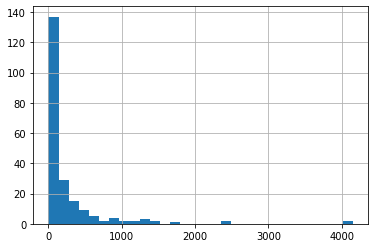

In [287]:
y.hist(bins = 30)

In [288]:
y.mean()

257.57674418604654

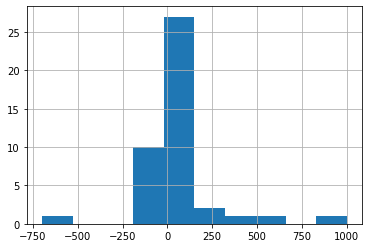

In [289]:
residuals = y_pred - y_test
residuals.hist()

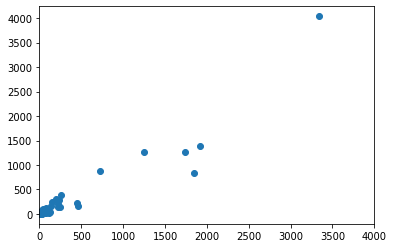

In [296]:
plt.scatter(x=y_pred, y = y_test)
#plt.yscale("log")
#plt.xscale("log")
plt.xlim([0,4000]);


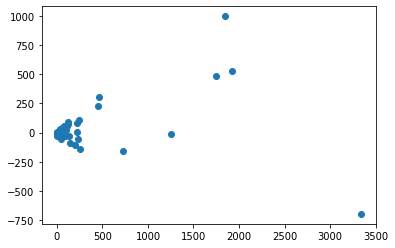

In [294]:
plt.scatter(x=y_pred, y = residuals)